# RFM Scaling Experiments

This notebook is only for experimentation and plotting of results. For actual runs/plot generation, see `scaling.py`.

In [1]:
%load_ext autoreload

%autoreload 2

import os

os.chdir("../")

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from src.rfm import *
from tqdm import trange

%config InlineBackend.figure_format = 'retina'

# Experiment Setup

Let a full dataset $X \in \mathbb{R}^{n \times d}$ be generated, where $n=100$ and $d = 200$.

Separately, we have the target function:
$$f(\vec{x}) = 5x_1^3 + 2x_2^2 + 10x_3$$

For every $d' \in [10, 200]$ we will perform the following:
1. Take the vertical slice $X'$ of shape $(n,d')$ as our dataset.
2. Compute $y' = f(X')$
3. Produce train, val (0.1), and test (0.2) splits.
4. Train an RFM model, validating on each iteration t (up to 10) and taking the model which best minimizes validation MSE.
5. Test the model on the test set to get test MSE.

Repeat the simulation 100 times, generating a new $X$ each time.

In [76]:
n, D = 100, 200


X_full = np.random.normal(size=(n, D))
f = lambda X: (5*np.power(X[:, 0], 3) + 2*np.power(X[:, 1], 2) + 10*X[:, 2]).reshape(-1, 1)
y = f(X_full)

X_full.shape, y.shape

((100, 200), (100, 1))

In [79]:
train_MSE = []
test_MSE = []
mse_hist = []

for d in trange(10, 201):

    X = X_full[:, :d] * (1 / np.sqrt(d))

    test_split_size = 0.2
    val_split_size = 0.1
    n_test_split = int(n * test_split_size)
    n_val_split = int(n * val_split_size)

    X_train, X_val, X_test = X[:n-n_test_split-n_val_split], X[n-n_test_split-n_val_split:n-n_test_split], X[n-n_test_split:]

    # recompute y
    y_train = f(X_train)
    y_val = f(X_val)
    y_test = f(X_test)

    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

    model = RFM()
    mse_hist.append(model.fit(X_train, y_train, X_val, y_val, norm_control=True))
    y_hat = model.predict(X_train)
    train_MSE.append(utils.mse(y_train, y_hat))
    test_MSE.append(model.score(X_test, y_test))


  0%|          | 0/191 [00:00<?, ?it/s]

(70, 10) (100, 1) (10, 10) (100, 1) (20, 10) (100, 1)


ValueError: operands could not be broadcast together with shapes (70,70) (100,100) 

In [27]:
X_train.shape, X_val.shape, X_test.shape

((70, 50), (10, 50), (20, 50))

In [73]:
model = RFM()

model.fit(X_train, y_train, X_val, y_val, norm_control=True)

/home/arunavgupta/Documents/UCSD/ml-theory-capstone/src/utils.py:102: RuntimeWarning: divide by zero encountered in true_divide
  K = K / dist


In [74]:
model.M.shape

(50, 50)

In [75]:
model.score(X_test, y_test)

0.7867129496052342

## Aside: Norm Controlling

Early tests of the RFM showed that when the norm of M was high, the model would overfit. In order to control this, we implement a simple norm control system based on SVD.
Given $M = \frac{1}{n}\sum J^TJ$, 
1. Decompose J into its SVD u, s, v.
2. Take the top_p% of singular values and use them to reconstruct J.

Below we can see how modifying `top_p` does what we desired: Lower `top_p` enforces a stricter control on the norm, at the expense of distance to the original J.

In [50]:
a = np.random.normal(size=(70, 1, 50))
aT = np.swapaxes(a, 1, 2)
(aT @ a).shape

(70, 50, 50)

In [56]:
norm_diff = np.zeros(10)
norm = np.zeros(10)
p_test = np.linspace(0.1, 1, 10)

for i, p in enumerate(p_test):
    reconstructed = utils.rsvd_norm_control(a[:, 0, :], keep_p=p)
    norm_diff[i] = np.linalg.norm(a[:, 0, :] - reconstructed)
    norm[i] = np.linalg.norm(reconstructed)

Text(0, 0.5, 'norm')

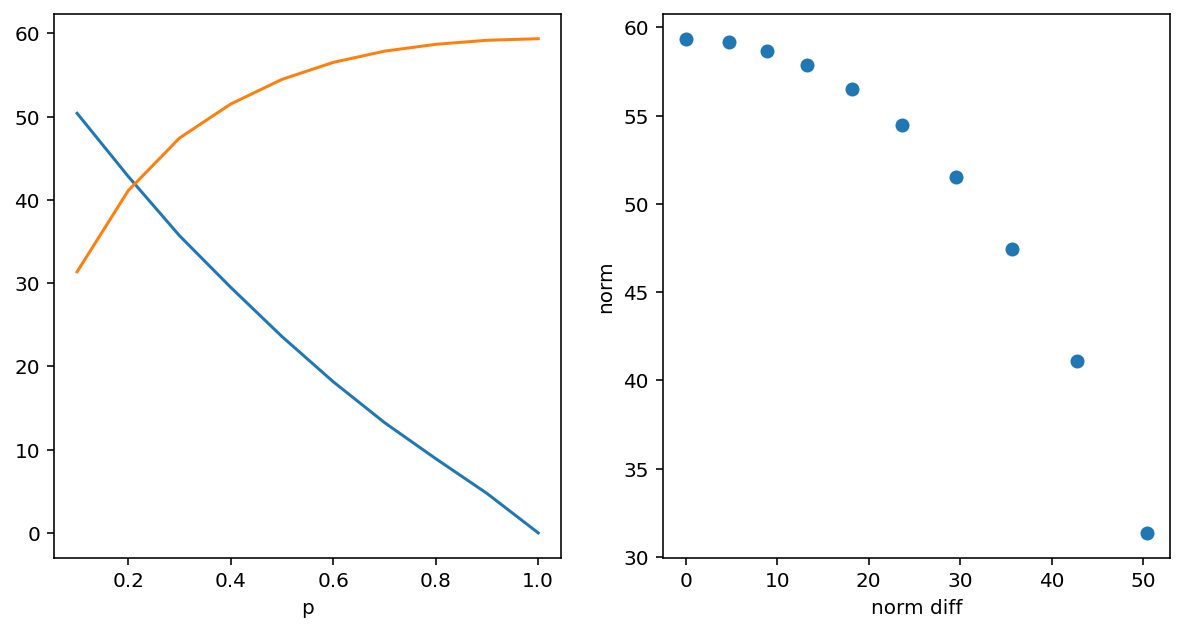

In [57]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].plot(p_test, norm_diff)
ax[0].plot(p_test, norm)
ax[0].set_xlabel("p")

ax[1].scatter(norm_diff, norm)
ax[1].set_xlabel("norm diff")
ax[1].set_ylabel("norm")